In [4]:
import os
import numpy as np
import shutil
import glob
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6



In [6]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
train_files = glob.glob('./data/pets_images/train/*.jpg')
test_files = glob.glob('./data/pets_images/test/*.jpg')
validation_files = glob.glob('./data/pets_images/validation/*.jpg')

train_images = []; train_labels = []
test_images = []; test_labels = []
validation_images = []; validation_labels = []

for file in tqdm(train_files):
    img = load_img(file)
    img = img_to_array(img)
    train_images.append(img)
    if 'cat' in file:
        train_labels.append(0)
    else:
        train_labels.append(1)

for file in tqdm(test_files):
    img = load_img(file)
    img = img_to_array(img)
    test_images.append(img)
    if 'cat' in file:
        test_labels.append(0)
    else:
        test_labels.append(1)
        
for file in tqdm(validation_files):
    img = load_img(file)
    img = img_to_array(img)
    validation_images.append(img)
    if 'cat' in file:
        validation_labels.append(0)
    else:
        validation_labels.append(1)
        
train_images = np.array(train_images)
test_images = np.array(test_images)
validation_images = np.array(validation_images)

100%|██████████| 3751/3751 [00:27<00:00, 136.26it/s]


In [20]:
batch_size = 32

n_train = train_images.shape[0]
n_val = validation_images.shape[0]

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_generator = validation_datagen.flow(validation_images, validation_labels, batch_size=batch_size)

In [25]:
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = (150, 150, 3)

conv_base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_4 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 3,539,457
Non-trainable params: 54,336,736
_________________________________________________________________


In [26]:
import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])     

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.functional.Fun...,inception_resnet_v2,False
1,<tensorflow.python.keras.layers.core.Flatten o...,flatten_4,True
2,<tensorflow.python.keras.layers.core.Dense obj...,dense_8,True
3,<tensorflow.python.keras.layers.core.Dropout o...,dropout_4,True
4,<tensorflow.python.keras.layers.core.Dense obj...,dense_9,True


In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "model/irnetv2_transfer_learn_dogvscat.h5"

save_model_cb = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
# callback to stop the training if no improvement
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min')

callbacks_list = [save_model_cb, early_stopping_cb]

history = model.fit_generator(train_generator, steps_per_epoch=200, epochs=100,
                              validation_data=validation_generator, validation_steps=75,
                              verbose=2, callbacks=callbacks_list)

Epoch 1/100
200/200 - 45s - loss: 0.3647 - accuracy: 0.8694 - val_loss: 0.1022 - val_accuracy: 0.9575

Epoch 00001: val_accuracy improved from -inf to 0.95750, saving model to model\irnetv2_transfer_learn_dogvscat.h5
Epoch 2/100
200/200 - 33s - loss: 0.2364 - accuracy: 0.9077 - val_loss: 0.0892 - val_accuracy: 0.9646

Epoch 00002: val_accuracy improved from 0.95750 to 0.96458, saving model to model\irnetv2_transfer_learn_dogvscat.h5
Epoch 3/100
200/200 - 33s - loss: 0.2207 - accuracy: 0.9067 - val_loss: 0.0679 - val_accuracy: 0.9733

Epoch 00003: val_accuracy improved from 0.96458 to 0.97333, saving model to model\irnetv2_transfer_learn_dogvscat.h5
Epoch 4/100
200/200 - 32s - loss: 0.2059 - accuracy: 0.9152 - val_loss: 0.0794 - val_accuracy: 0.9696

Epoch 00004: val_accuracy did not improve from 0.97333
Epoch 5/100
200/200 - 32s - loss: 0.1923 - accuracy: 0.9230 - val_loss: 0.0788 - val_accuracy: 0.9700

Epoch 00005: val_accuracy did not improve from 0.97333
Epoch 6/100
200/200 - 33s -

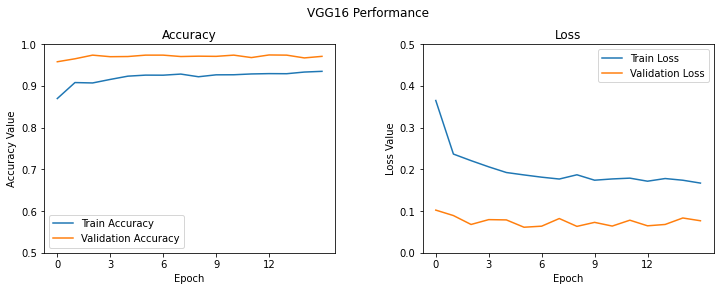

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
ax1.set_ylim((0.5,1))
ax2.set_ylim((0,0.5))

epoch_list = history.epoch
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [29]:
test_images /= 255
predict = model.predict(test_images)
predict = np.round(predict)

              precision    recall  f1-score   support

         Cat       0.98      0.95      0.97      1913
         Dog       0.95      0.98      0.97      1836

    accuracy                           0.97      3749
   macro avg       0.97      0.97      0.97      3749
weighted avg       0.97      0.97      0.97      3749



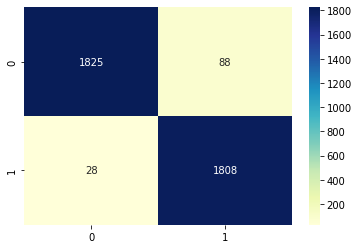

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

report = classification_report(test_labels, predict, target_names=['Cat', 'Dog'])
conf_mat = confusion_matrix(test_labels, predict)

print(report)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu')
plt.show()